In [5]:
import random
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

## Generation de dataset

In [ ]:
# Listes de descriptions textuelles
distances = ["à 1 mètre", "à 2 mètres", "à 5 mètres", "proche du robot"]
positions = ["devant le robot", "à gauche", "à droite", "derrière le robot"]
états = ["aucune obstruction visible", "un obstacle est détecté", "le robot est bloqué"]

# Générer des commandes en fonction des situations
def generate_textual_dataset(num_samples=1000):
    data = []
    for _ in range(num_samples):
        # Générer une situation
        situation = f"Il y a {random.choice(distances)} {random.choice(positions)}. {random.choice(états)}."

        # Définir une commande en fonction des règles
        if "devant" in situation and "obstacle" in situation:
            commande = "arreter"
        elif "à gauche" in situation and "obstacle" in situation and "à droite" not in situation:
            commande = "tourner"
        elif "à droite" in situation and "obstacle" in situation and "à gauche" not in situation:
            commande = "tourner"
        elif "à gauche" in situation and "obstacle" in situation and "à droite" in situation:
            commande = "revenir"
        else:
            commande = "revenir"  # Par défaut

        data.append({"situation": situation, "commande": commande})

    return pd.DataFrame(data)

Dataset textuel généré et sauvegardé sous 'robot_text_commands.csv'.


In [66]:
# Générer le dataset
dataset = generate_textual_dataset(1000)
dataset.to_csv("/content/Robot_Action_Prediction/robot_text_commands.csv", index=False)
print("Dataset textuel généré et sauvegardé sous 'robot_text_commands.csv'.")

Dataset textuel généré et sauvegardé sous 'robot_text_commands.csv'.


In [3]:
from config import *
##https://github.com/ourahma/Robot_Action_Prediction.git
!git clone https://{os.environ['GITHUB_TOKEN']}@github.com/ourahma/Robot_Action_Prediction.git

Cloning into 'Robot_Action_Prediction'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 4.14 KiB | 4.14 MiB/s, done.


In [67]:
# Charger le dataset
dataset = pd.read_csv("/content/Robot_Action_Prediction/robot_text_commands.csv")

augmenter_dataset(dataset["situation"])

,situation
0,Il y a à 5 mètres en face de le robot. un obst...
1,Il y a à 5 mètres à droite. un obstacle est dé...
2,Il y a proche du robot à gauche. un obstacle e...
3,Il y a proche du robot derrière le robot. aucu...
4,Il y a proche du robot derrière le robot. un o...
...,...
995,Il y a à 5 mètres à gauche. aucune obstruction...
996,Il y a à 1 mètre à gauche. aucune obstruction ...
997,Il y a à 2 mètres en face de le robot. un obst...
998,Il y a à 2 mètres en face de le robot. le robo...


In [68]:
dataset['commande'].value_counts()

,count
commande,
revenir,714
tourner,196
arreter,90


In [69]:
# Extraire les colonnes
texts = dataset["situation"].values
labels = dataset["commande"].values


Nettoyage et encodage des données

In [70]:

# Prétraitement des données
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['situation'])
X = tokenizer.texts_to_sequences(dataset['situation'])
X = pad_sequences(X, maxlen=20, padding='post')

# Encodage des étiquettes
y = pd.get_dummies(dataset['commande']).values



Division des données en ensembles d'entraînement et de test

In [71]:
from sklearn.model_selection import train_test_split

# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Taille des données d'entraînement : {X_train.shape}")
print(f"Taille des données de test : {X_test.shape}")

Taille des données d'entraînement : (800, 20)
Taille des données de test : (200, 20)


Construction du modèle LSTM

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Définir les dimensions du vocabulaire et de l'input
vocab_size = len(tokenizer.word_index) + 1  # taille du vocabulaire
embedding_dim = 50  # dimension des vecteurs d'embedding
max_len = 20  # longueur maximale de l'entrée (après padding)


# Créer le modèle LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.build(input_shape=(None, max_len))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)             │ (None, 20, 50)              │           1,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,085 (121.43 KB)

 Trainable params: 31,085 (121.43 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5948 - loss: 0.9895 - val_accuracy: 0.7400 - val_loss: 0.6767
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7220 - loss: 0.6163 - val_accuracy: 0.9000 - val_loss: 0.2431
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9158 - loss: 0.2195 - val_accuracy: 0.8750 - val_loss: 0.3018
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9180 - loss: 0.1926 - val_accuracy: 0.9300 - val_loss: 0.1372
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9804 - loss: 0.1038 - val_accuracy: 1.0000 - val_loss: 0.0331


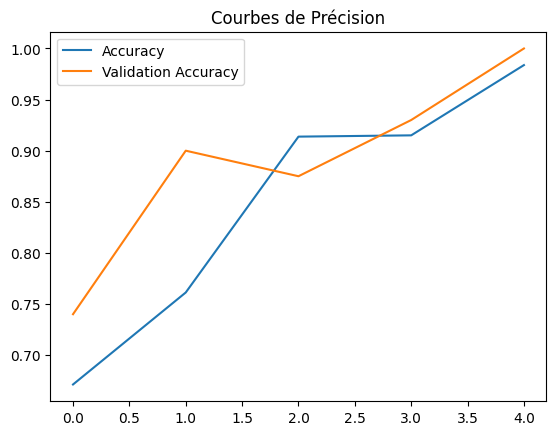

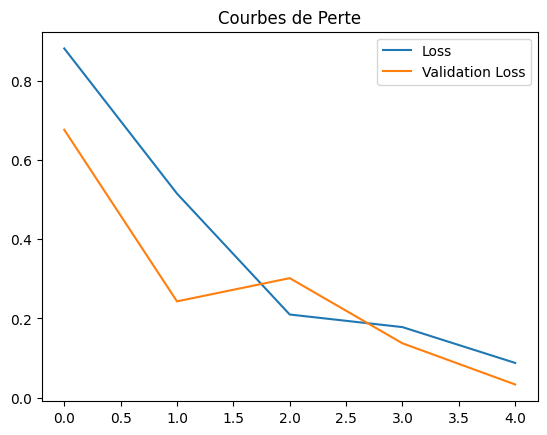

In [79]:
import matplotlib.pyplot as plt

# Précision
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Courbes de Précision')
plt.show()

# Perte
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Courbes de Perte')
plt.show()


In [80]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Précision sur les données de test : {test_accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0351 
Précision sur les données de test : 1.00


In [85]:
# Sauvegarder le modèle
model_path='/content/Robot_Action_Prediction/lstm_robot_model.h5'
model.save(model_path)
print("Le modèle a été sauvegardé sous 'lstm_robot_model.h5'")

Le modèle a été sauvegardé sous 'lstm_robot_model.h5'


La fonction de prediction

In [83]:
# Fonction de prédiction
def predict_command(situation, tokenizer, model, max_len=20):
    tokens = tokenizer.texts_to_sequences([situation])
    padded_tokens = pad_sequences(tokens, maxlen=max_len, padding='post')
    prediction = model.predict(padded_tokens)
    predicted_class = np.argmax(prediction, axis=1)
    commands = ["arreter", "tourner", "revenir"]
    return commands[predicted_class[0]]

In [86]:
# Charger le modèle sauvegardé
loaded_model = load_model(model_path)
print("Modèle chargé avec succès")

Modèle chargé avec succès


In [87]:
# Tester la prédiction
situation = "Il y a à 2 mètres devant le robot. un obstacle est détecté."
predicted_command = predict_command(situation, tokenizer, model)
print(f"Commande prédite : {predicted_command}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Commande prédite : arreter


In [89]:
# Tester à nouveau avec le modèle chargé
situation = "Il y a à 5 mètres a gauche le robot. un obstacle est détecté."
predicted_command = predict_command(situation, tokenizer, loaded_model)
print(f"Commande prédite avec le modèle chargé : {predicted_command}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Commande prédite avec le modèle chargé : tourner


In [90]:
!pwd

/content


In [91]:
!cd /content/Robot_Action_Prediction/

In [94]:
!git status

fatal: not a git repository (or any of the parent directories): .git
